# Phase 3.5: 补充Experiment

> **目标**: 基于Phase 3Discovery，补充关键Experiment以完善论文论证
> 
> **Execute时间**: 2026Years1Months
> 
> **Experiment内容**:
> - E13: 简单Rule基线完整Evaluation（cwm>0）
> - E14: 排除cwmFeaturesAnalysis（其他FeaturesContribution）
> - E15: Rule阈值调整Experiment（可选）

---

## 0. Environment Setup

In [1]:
#   Import necessary libraries
import os
import sys
import json
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#   scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

#   XGBoost
try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    HAS_XGBOOST = False
    print("⚠ XGBoost not installed, will skip XGBoost experiment")

#   Add project path
PROJECT_ROOT = Path(r"c:\Users\Echo\Desktop\modbus-detection")
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

#   ValidationPath
print(f"Project root: {PROJECT_ROOT}")
print(f"src directory exists: {(PROJECT_ROOT / 'src').exists()}")

from config import (
    DATA_PROCESSED, DATA_SPLITS, MODELS_DIR, FIGURES_DIR, TABLES_DIR,
    RANDOM_SEED, ensure_dirs
)
from feature_extractor import get_feature_names, get_feature_groups

#   Setup
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-whitegrid')

#   Ensure directories exist
ensure_dirs()

#   Random seed
np.random.seed(RANDOM_SEED)

#   Constant定义
POS_LABEL = 'Attack'
N_FOLDS = 5

print("="*60)
print("Phase 3.5: Supplementary Experiments")
print("="*60)
print(f"\nExecution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random seed: {RANDOM_SEED}")

Project root: c:\Users\Echo\Desktop\modbus-detection
src directory exists: True
✓ All directories created
Phase 3.5: Supplementary Experiments

Execution time: 2026-01-22 14:20:49
Random seed: 42


## 1. Data Loading

In [2]:
#   Load Phase 2 train/test sets
print("Loading Phase 2 dataset...")

df_train = pd.read_parquet(DATA_SPLITS / 'train.parquet')
df_val = pd.read_parquet(DATA_SPLITS / 'val.parquet')
df_test = pd.read_parquet(DATA_SPLITS / 'test.parquet')

#   合并Training集和Validation集
df_train_full = pd.concat([df_train, df_val], ignore_index=True)

print(f"\n数据集大小:")
print(f"  训练集: {len(df_train):,} 样本")
print(f"  验证集: {len(df_val):,} 样本")
print(f"  测试集: {len(df_test):,} 样本")
print(f"  训练+验证: {len(df_train_full):,} 样本")

#   获取Features名
feature_names = get_feature_names()
feature_groups = get_feature_groups()

print(f"\n特征数量: {len(feature_names)}")

Loading Phase 2 dataset...

数据集大小:
  训练集: 83,078 样本
  验证集: 15,371 样本
  测试集: 19,760 样本
  训练+验证: 98,449 样本

特征数量: 44


In [3]:
#   准备Training和Test数据
X_train_full = df_train_full[feature_names].values
y_train_full = df_train_full['label'].values

X_test = df_test[feature_names].values
y_test = df_test['label'].values

print(f"训练数据: {X_train_full.shape}")
print(f"测试数据: {X_test.shape}")

#   StatisticsClass别Distribution
print(f"\n测试集类别分布:")
print(f"  Normal: {(y_test == 'Normal').sum():,}")
print(f"  Attack: {(y_test == 'Attack').sum():,}")

训练数据: (98449, 44)
测试数据: (19760, 44)

测试集类别分布:
  Normal: 18,648
  Attack: 1,112


## 2. 辅助Function定义

In [4]:
def evaluate_model(y_true, y_pred, y_proba=None):
    """计算评估指标"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
        'recall': recall_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
        'f1': f1_score(y_true, y_pred, pos_label=POS_LABEL, zero_division=0),
    }
    
    if y_proba is not None:
        y_true_binary = (y_true == POS_LABEL).astype(int)
        try:
            metrics['auc_roc'] = roc_auc_score(y_true_binary, y_proba)
            metrics['auc_pr'] = average_precision_score(y_true_binary, y_proba)
        except:
            metrics['auc_roc'] = np.nan
            metrics['auc_pr'] = np.nan
    
    return metrics


def cross_validate_model(model_class, model_params, X, y, feature_subset=None, n_folds=5):
    """执行5-fold交叉验证"""
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
    
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_fold_train = X[train_idx]
        y_fold_train = y[train_idx]
        X_fold_val = X[val_idx]
        y_fold_val = y[val_idx]
        
        #   如果指定了Features子集
        if feature_subset is not None:
            X_fold_train = X_fold_train[:, feature_subset]
            X_fold_val = X_fold_val[:, feature_subset]
        
        #   TrainingModels
        model = model_class(**model_params)
        model.fit(X_fold_train, y_fold_train)
        
        #   Prediction
        y_pred = model.predict(X_fold_val)
        
        #   获取概率
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X_fold_val)
            attack_idx = list(model.classes_).index(POS_LABEL)
            y_proba = proba[:, attack_idx]
        else:
            y_proba = None
        
        #   Evaluation
        fold_metrics = evaluate_model(y_fold_val, y_pred, y_proba)
        fold_metrics['fold'] = fold
        cv_results.append(fold_metrics)
    
    return pd.DataFrame(cv_results)


def train_and_evaluate(model_class, model_params, X_train, y_train, X_test, y_test, feature_subset=None):
    """训练模型并在测试集上评估"""
    #   如果指定了Features子集
    if feature_subset is not None:
        X_train_sub = X_train[:, feature_subset]
        X_test_sub = X_test[:, feature_subset]
    else:
        X_train_sub = X_train
        X_test_sub = X_test
    
    #   Training
    start_time = time.time()
    model = model_class(**model_params)
    model.fit(X_train_sub, y_train)
    train_time = time.time() - start_time
    
    #   Prediction
    start_time = time.time()
    y_pred = model.predict(X_test_sub)
    predict_time = time.time() - start_time
    
    #   获取概率
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(X_test_sub)
        attack_idx = list(model.classes_).index(POS_LABEL)
        y_proba = proba[:, attack_idx]
    else:
        y_proba = None
    
    #   Evaluation
    metrics = evaluate_model(y_test, y_pred, y_proba)
    metrics['train_time'] = train_time
    metrics['predict_time'] = predict_time
    metrics['predict_time_per_sample'] = predict_time / len(X_test_sub) * 1000  #   ms
    
    return model, y_pred, y_proba, metrics


def get_feature_indices(feature_names_list, target_features):
    """获取特征索引"""
    return [feature_names_list.index(f) for f in target_features if f in feature_names_list]


print("✓ 辅助函数定义完成")

✓ 辅助函数定义完成


---

## 3. E13: 简单Rule基线完整Evaluation

### 目的
量化简单Rule `consecutive_write_max > 0` 的Detection能力，作为所有MLMethodology的baseline。

### Phase 3 Discovery回顾
- SCADAScenario: Attack cwm>0 = 100%, Normal cwm>0 = 0%
- IEDScenario: Attack cwm>0 = 100%, Normal cwm>0 = 0%
- 简单Rule `cwm>0` 可能已接近最优Detection性能

In [5]:
print("="*60)
print("E13: Simple Rule Baseline Complete Evaluation")
print("="*60)

#   Load full dataset (for per-scenario analysis)
df_all = pd.read_parquet(DATA_PROCESSED / 'features_15s_filtered.parquet')
print(f"\n完整数据集: {len(df_all):,} 样本")
print(f"场景分布:\n{df_all['scenario'].value_counts()}")

E13: Simple Rule Baseline Complete Evaluation

完整数据集: 118,209 样本
场景分布:
scenario
benign      44821
scada       38799
ied         34582
external        7
Name: count, dtype: int64


In [6]:
#   Step1: AnalysiscwmFeatures在Test集中的Distribution
print("\n" + "="*50)
print("Step 1: cwm feature distribution analysis")
print("="*50)

#   Test集中cwmDistribution
test_attack = df_test[df_test['label'] == 'Attack']
test_normal = df_test[df_test['label'] == 'Normal']

print(f"\n测试集Attack样本 (n={len(test_attack)}):")
print(f"  cwm>0: {(test_attack['consecutive_write_max'] > 0).sum()} ({(test_attack['consecutive_write_max'] > 0).mean()*100:.1f}%)")
print(f"  cwm>1: {(test_attack['consecutive_write_max'] > 1).sum()} ({(test_attack['consecutive_write_max'] > 1).mean()*100:.1f}%)")
print(f"  cwm>2: {(test_attack['consecutive_write_max'] > 2).sum()} ({(test_attack['consecutive_write_max'] > 2).mean()*100:.1f}%)")
print(f"  cwm最大值: {test_attack['consecutive_write_max'].max()}")
print(f"  cwm均值: {test_attack['consecutive_write_max'].mean():.2f}")

print(f"\n测试集Normal样本 (n={len(test_normal)}):")
print(f"  cwm>0: {(test_normal['consecutive_write_max'] > 0).sum()} ({(test_normal['consecutive_write_max'] > 0).mean()*100:.1f}%)")
print(f"  cwm最大值: {test_normal['consecutive_write_max'].max()}")
print(f"  cwm均值: {test_normal['consecutive_write_max'].mean():.2f}")


Step 1: cwm feature distribution analysis

测试集Attack样本 (n=1112):
  cwm>0: 1112 (100.0%)
  cwm>1: 1107 (99.6%)
  cwm>2: 80 (7.2%)
  cwm最大值: 2609
  cwm均值: 37.01

测试集Normal样本 (n=18648):
  cwm>0: 532 (2.9%)
  cwm最大值: 2
  cwm均值: 0.06


In [7]:
#   Step2: 简单Rule基线 - cwm > 0
print("\n" + "="*50)
print("Step 2: Simple rule baseline (cwm > 0)")
print("="*50)

def apply_simple_rule(df, threshold=0):
    """
    Apply simple rule: consecutive_write_max > threshold → Attack
    """
    rule_attack = df['consecutive_write_max'] > threshold
    y_pred = np.where(rule_attack, 'Attack', 'Normal')
    return y_pred, rule_attack

#   应用Rule cwm > 0
y_pred_rule_0, rule_mask_0 = apply_simple_rule(df_test, threshold=0)

#   Evaluation
metrics_rule_0 = evaluate_model(y_test, y_pred_rule_0)

print(f"\n[Simple Rule cwm>0 Performance]")
print(f"  Accuracy:  {metrics_rule_0['accuracy']:.4f}")
print(f"  Precision: {metrics_rule_0['precision']:.4f}")
print(f"  Recall:    {metrics_rule_0['recall']:.4f}")
print(f"  F1:        {metrics_rule_0['f1']:.4f}")

#   Confusion Matrix
cm_rule_0 = confusion_matrix(y_test, y_pred_rule_0, labels=['Normal', 'Attack'])
print(f"\n混淆矩阵 [Normal, Attack]:")
print(f"  TN={cm_rule_0[0,0]:,}, FP={cm_rule_0[0,1]:,}")
print(f"  FN={cm_rule_0[1,0]:,}, TP={cm_rule_0[1,1]:,}")


Step 2: Simple rule baseline (cwm > 0)

[Simple Rule cwm>0 Performance]
  Accuracy:  0.9731
  Precision: 0.6764
  Recall:    1.0000
  F1:        0.8070

混淆矩阵 [Normal, Attack]:
  TN=18,116, FP=532
  FN=0, TP=1,112


In [8]:
#   Step3: 与MLMethodologyComparison
print("\n" + "="*50)
print("步骤3: 与ML方法对比")
print("="*50)

#   RFParameter
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': None,
    'class_weight': 'balanced',
    'random_state': RANDOM_SEED,
    'n_jobs': -1
}

#   TrainingRFModels
print("\n训练Random Forest模型...")
rf_model, y_pred_rf, y_proba_rf, metrics_rf = train_and_evaluate(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    X_test, y_test
)

#   XGBoost（如果可用）
metrics_xgb = None
if HAS_XGBOOST:
    print("训练XGBoost模型...")
    
    #   为XGBoost准备数值Labels
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train_full)
    y_test_enc = le.transform(y_test)
    
    XGB_PARAMS = {
        'n_estimators': 100, 
        'max_depth': 6, 
        'scale_pos_weight': 21.7,
        'random_state': RANDOM_SEED, 
        'use_label_encoder': False, 
        'eval_metric': 'logloss'
    }
    
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(**XGB_PARAMS)
    xgb_model.fit(X_train_full, y_train_enc)
    train_time_xgb = time.time() - start_time
    
    start_time = time.time()
    y_pred_xgb_enc = xgb_model.predict(X_test)
    predict_time_xgb = time.time() - start_time
    
    y_pred_xgb = le.inverse_transform(y_pred_xgb_enc)
    y_proba_xgb = xgb_model.predict_proba(X_test)[:, 0]  #   Attack is class 0
    
    metrics_xgb = evaluate_model(y_test, y_pred_xgb, y_proba_xgb)
    metrics_xgb['train_time'] = train_time_xgb
    metrics_xgb['predict_time'] = predict_time_xgb
    metrics_xgb['predict_time_per_sample'] = predict_time_xgb / len(X_test) * 1000

print("\n✓ 模型训练完成")


步骤3: 与ML方法对比

训练Random Forest模型...
训练XGBoost模型...

✓ 模型训练完成


In [9]:
#   汇总ComparisonResults
print("\n" + "="*50)
print("E13 Results Summary: Simple Rule vs ML Methods")
print("="*50)

e13_results = [
    {
        'method': 'Simple Rule (cwm>0)',
        'accuracy': metrics_rule_0['accuracy'],
        'precision': metrics_rule_0['precision'],
        'recall': metrics_rule_0['recall'],
        'f1': metrics_rule_0['f1'],
        'inference_time_ms': 0.0001,  #   Rule几乎无开销
        'model_size_mb': 0.0
    },
    {
        'method': 'Random Forest',
        'accuracy': metrics_rf['accuracy'],
        'precision': metrics_rf['precision'],
        'recall': metrics_rf['recall'],
        'f1': metrics_rf['f1'],
        'inference_time_ms': metrics_rf['predict_time_per_sample'],
        'model_size_mb': sys.getsizeof(pickle.dumps(rf_model)) / 1024 / 1024
    }
]

if metrics_xgb:
    e13_results.append({
        'method': 'XGBoost',
        'accuracy': metrics_xgb['accuracy'],
        'precision': metrics_xgb['precision'],
        'recall': metrics_xgb['recall'],
        'f1': metrics_xgb['f1'],
        'inference_time_ms': metrics_xgb['predict_time_per_sample'],
        'model_size_mb': sys.getsizeof(pickle.dumps(xgb_model)) / 1024 / 1024
    })

df_e13 = pd.DataFrame(e13_results)
print("\n" + df_e13.to_string(index=False))

#   计算ML相对于简单Rule的增益
print("\n" + "="*50)
print("ML Method Gain Analysis vs Simple Rule")
print("="*50)
base_f1 = metrics_rule_0['f1']
print(f"\nSimple Rule Baseline F1: {base_f1:.4f}")
print(f"\nRandom Forest:")
print(f"  F1增益: {metrics_rf['f1'] - base_f1:.4f} ({(metrics_rf['f1'] - base_f1)/base_f1*100:+.2f}%)")
print(f"  Recall变化: {metrics_rf['recall'] - metrics_rule_0['recall']:.4f}")
print(f"  Precision变化: {metrics_rf['precision'] - metrics_rule_0['precision']:.4f}")

if metrics_xgb:
    print(f"\nXGBoost:")
    print(f"  F1增益: {metrics_xgb['f1'] - base_f1:.4f} ({(metrics_xgb['f1'] - base_f1)/base_f1*100:+.2f}%)")
    print(f"  Recall变化: {metrics_xgb['recall'] - metrics_rule_0['recall']:.4f}")
    print(f"  Precision变化: {metrics_xgb['precision'] - metrics_rule_0['precision']:.4f}")


E13 Results Summary: Simple Rule vs ML Methods

       method  accuracy  precision   recall       f1  inference_time_ms  model_size_mb
 Simple Rule (cwm>0)  0.973077   0.676399 1.000000 0.806967           0.000100       0.000000
Random Forest  0.992055   0.948357 0.908273 0.927882           0.006464       9.988576
      XGBoost  0.995800   0.988604 0.936151 0.961663           0.001114       0.236539

ML Method Gain Analysis vs Simple Rule

Simple Rule Baseline F1: 0.8070

Random Forest:
  F1增益: 0.1209 (+14.98%)
  Recall变化: -0.0917
  Precision变化: 0.2720

XGBoost:
  F1增益: 0.1547 (+19.17%)
  Recall变化: -0.0638
  Precision变化: 0.3122


In [10]:
#   Step4: 分ScenarioEvaluation
print("\n" + "="*50)
print("Step 4: Per-scenario Evaluation (Simple Rule cwm>0)")
print("="*50)

#   按ScenarioAnalysis
scenarios = ['benign', 'scada', 'ied']
scenario_results = []

for scenario in scenarios:
    df_scenario = df_all[df_all['scenario'] == scenario]
    
    if len(df_scenario) == 0:
        continue
    
    y_true_scenario = df_scenario['label'].values
    y_pred_scenario, _ = apply_simple_rule(df_scenario, threshold=0)
    
    #   Statistics
    n_attack = (y_true_scenario == 'Attack').sum()
    n_normal = (y_true_scenario == 'Normal').sum()
    
    #   Evaluation（如果有两个Class别）
    if n_attack > 0 and n_normal > 0:
        metrics_scenario = evaluate_model(y_true_scenario, y_pred_scenario)
    elif n_attack > 0:  #   只有Attack
        metrics_scenario = {
            'accuracy': accuracy_score(y_true_scenario, y_pred_scenario),
            'precision': np.nan,
            'recall': (y_pred_scenario == 'Attack').sum() / n_attack,
            'f1': np.nan
        }
    else:  #   只有Normal
        metrics_scenario = {
            'accuracy': accuracy_score(y_true_scenario, y_pred_scenario),
            'precision': np.nan,
            'recall': np.nan,
            'f1': np.nan
        }
    
    scenario_results.append({
        'scenario': scenario,
        'n_samples': len(df_scenario),
        'n_attack': n_attack,
        'n_normal': n_normal,
        'accuracy': metrics_scenario['accuracy'],
        'precision': metrics_scenario.get('precision', np.nan),
        'recall': metrics_scenario.get('recall', np.nan),
        'f1': metrics_scenario.get('f1', np.nan)
    })
    
    print(f"\n{scenario.upper()}场景 (n={len(df_scenario):,}, Attack={n_attack:,}, Normal={n_normal:,}):")
    print(f"  Accuracy:  {metrics_scenario['accuracy']:.4f}")
    if not np.isnan(metrics_scenario.get('f1', np.nan)):
        print(f"  Precision: {metrics_scenario['precision']:.4f}")
        print(f"  Recall:    {metrics_scenario['recall']:.4f}")
        print(f"  F1:        {metrics_scenario['f1']:.4f}")

df_scenario_results = pd.DataFrame(scenario_results)


Step 4: Per-scenario Evaluation (Simple Rule cwm>0)

BENIGN场景 (n=44,821, Attack=0, Normal=44,821):
  Accuracy:  0.9058

SCADA场景 (n=38,799, Attack=3,811, Normal=34,988):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000

IED场景 (n=34,582, Attack=1,400, Normal=33,182):
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1:        1.0000


In [11]:
#   Save E13 results
df_e13.to_csv(TABLES_DIR / 'phase3.5_e13_rule_vs_ml.csv', index=False)
df_scenario_results.to_csv(TABLES_DIR / 'phase3.5_e13_scenario_results.csv', index=False)
print(f"\n✓ E13 results saved")


✓ E13 results saved


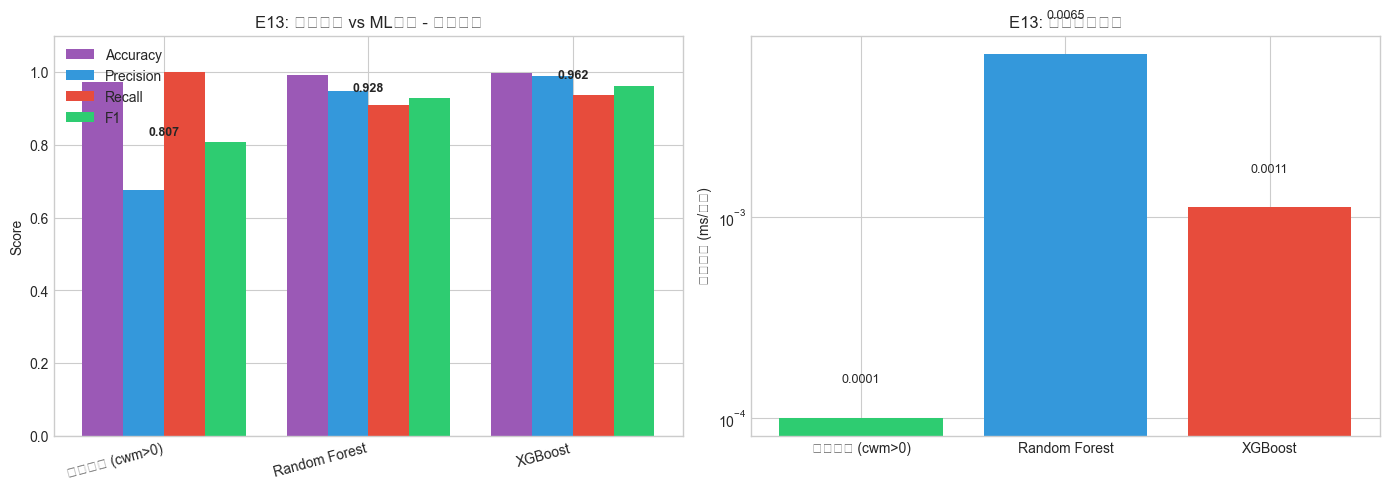


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e13_comparison.png


In [12]:
#   绘制E13ComparisonFigure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#   Figure1: 性能Comparison
ax1 = axes[0]
methods = df_e13['method']
x = np.arange(len(methods))
width = 0.2

ax1.bar(x - 1.5*width, df_e13['accuracy'], width, label='Accuracy', color='#  9b59b6')
ax1.bar(x - 0.5*width, df_e13['precision'], width, label='Precision', color='#  3498db')
ax1.bar(x + 0.5*width, df_e13['recall'], width, label='Recall', color='#  e74c3c')
ax1.bar(x + 1.5*width, df_e13['f1'], width, label='F1', color='#  2ecc71')

ax1.set_ylabel('Score')
ax1.set_title('E13: Simple Rule vs ML Methods - Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, rotation=15, ha='right')
ax1.legend()
ax1.set_ylim(0, 1.1)

#   添加数值Labels
for i, method in enumerate(methods):
    ax1.text(i, df_e13.loc[i, 'f1'] + 0.02, f"{df_e13.loc[i, 'f1']:.3f}", 
             ha='center', fontsize=9, fontweight='bold')

#   Figure2: 推理效率Comparison
ax2 = axes[1]
colors = ['#  2ecc71', '#3498db', '#e74c3c']
bars = ax2.bar(methods, df_e13['inference_time_ms'], color=colors[:len(methods)])
ax2.set_ylabel('推理时间 (ms/样本)')
ax2.set_title('E13: 推理效率对比')
ax2.set_yscale('log')

#   添加数值Labels
for bar, val in zip(bars, df_e13['inference_time_ms']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.5, 
             f'{val:.4f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e13_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e13_comparison.png'}")

---

## 4. E14: 排除cwmFeaturesAnalysis

### 目的
Evaluation排除 `consecutive_write_max` 相关Features后，其他Features的真实Contribution。

### Experiment设计
- 移除Features: `consecutive_write_max`, `consecutive_write_mean`, `write_burst_count`
- Evaluation剩余41个Features的Detection能力

In [13]:
print("\n" + "="*60)
print("E14: Feature Analysis Excluding cwm")
print("="*60)

#   定义要移除的cwm相关Features
cwm_related_features = [
    'consecutive_write_max',
    'consecutive_write_mean',
    'write_burst_count'
]

#   获取排除cwm后的Features列Table
features_without_cwm = [f for f in feature_names if f not in cwm_related_features]

print(f"\n原始特征数量: {len(feature_names)}")
print(f"排除cwm相关特征: {cwm_related_features}")
print(f"剩余特征数量: {len(features_without_cwm)}")


E14: Feature Analysis Excluding cwm

原始特征数量: 44
排除cwm相关特征: ['consecutive_write_max', 'consecutive_write_mean', 'write_burst_count']
剩余特征数量: 41


In [14]:
#   获取Features索引
feature_idx_without_cwm = get_feature_indices(feature_names, features_without_cwm)

print(f"\n排除cwm后的特征索引数量: {len(feature_idx_without_cwm)}")


排除cwm后的特征索引数量: 41


In [15]:
#   Experiment组1: All Features (44个) - 作为基线
print("\n" + "="*50)
print("Experiment Group 1: All features (44)")
print("="*50)

#   5-fold CV
print("执行5-fold交叉验证...")
cv_all = cross_validate_model(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full
)
print(f"  CV F1: {cv_all['f1'].mean():.4f} ± {cv_all['f1'].std():.4f}")

#   Test集Evaluation
print("在测试集上评估...")
_, y_pred_all, y_proba_all, metrics_all = train_and_evaluate(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    X_test, y_test
)

print(f"  Test F1: {metrics_all['f1']:.4f}")
print(f"  Test Recall: {metrics_all['recall']:.4f}")
print(f"  Test Precision: {metrics_all['precision']:.4f}")


Experiment Group 1: All features (44)
执行5-fold交叉验证...
  CV F1: 0.9491 ± 0.0048
在测试集上评估...
  Test F1: 0.9279
  Test Recall: 0.9083
  Test Precision: 0.9484


In [16]:
#   Experiment组2: 排除cwm相关Features (41个)
print("\n" + "="*50)
print("Experiment Group 2: Excluding cwm features (41)")
print("="*50)

#   5-fold CV
print("执行5-fold交叉验证...")
cv_no_cwm = cross_validate_model(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    feature_subset=feature_idx_without_cwm
)
print(f"  CV F1: {cv_no_cwm['f1'].mean():.4f} ± {cv_no_cwm['f1'].std():.4f}")

#   Test集Evaluation
print("在测试集上评估...")
_, y_pred_no_cwm, y_proba_no_cwm, metrics_no_cwm = train_and_evaluate(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    X_test, y_test,
    feature_subset=feature_idx_without_cwm
)

print(f"  Test F1: {metrics_no_cwm['f1']:.4f}")
print(f"  Test Recall: {metrics_no_cwm['recall']:.4f}")
print(f"  Test Precision: {metrics_no_cwm['precision']:.4f}")


Experiment Group 2: Excluding cwm features (41)
执行5-fold交叉验证...
  CV F1: 0.9509 ± 0.0043
在测试集上评估...
  Test F1: 0.9265
  Test Recall: 0.9065
  Test Precision: 0.9474


In [17]:
#   Experiment组3: 仅Protocol LayerFeatures (13个)
print("\n" + "="*50)
print("Experiment Group 3: Protocol layer features only (13)")
print("="*50)

protocol_features = feature_groups['protocol']
protocol_idx = get_feature_indices(feature_names, protocol_features)

#   5-fold CV
print("执行5-fold交叉验证...")
cv_protocol = cross_validate_model(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    feature_subset=protocol_idx
)
print(f"  CV F1: {cv_protocol['f1'].mean():.4f} ± {cv_protocol['f1'].std():.4f}")

#   Test集Evaluation
print("在测试集上评估...")
_, y_pred_protocol, y_proba_protocol, metrics_protocol = train_and_evaluate(
    RandomForestClassifier, RF_PARAMS,
    X_train_full, y_train_full,
    X_test, y_test,
    feature_subset=protocol_idx
)

print(f"  Test F1: {metrics_protocol['f1']:.4f}")
print(f"  Test Recall: {metrics_protocol['recall']:.4f}")
print(f"  Test Precision: {metrics_protocol['precision']:.4f}")


Experiment Group 3: Protocol layer features only (13)
执行5-fold交叉验证...
  CV F1: 0.9534 ± 0.0054
在测试集上评估...
  Test F1: 0.9221
  Test Recall: 0.8939
  Test Precision: 0.9521


In [18]:
#   汇总E14Results
print("\n" + "="*60)
print("E14 Results Summary")
print("="*60)

e14_results = pd.DataFrame([
    {
        'experiment': '全部特征 (44个)',
        'n_features': len(feature_names),
        'cv_f1_mean': cv_all['f1'].mean(),
        'cv_f1_std': cv_all['f1'].std(),
        'test_f1': metrics_all['f1'],
        'test_recall': metrics_all['recall'],
        'test_precision': metrics_all['precision']
    },
    {
        'experiment': '排除cwm相关特征 (41个)',
        'n_features': len(features_without_cwm),
        'cv_f1_mean': cv_no_cwm['f1'].mean(),
        'cv_f1_std': cv_no_cwm['f1'].std(),
        'test_f1': metrics_no_cwm['f1'],
        'test_recall': metrics_no_cwm['recall'],
        'test_precision': metrics_no_cwm['precision']
    },
    {
        'experiment': '仅协议层特征 (13个)',
        'n_features': len(protocol_features),
        'cv_f1_mean': cv_protocol['f1'].mean(),
        'cv_f1_std': cv_protocol['f1'].std(),
        'test_f1': metrics_protocol['f1'],
        'test_recall': metrics_protocol['recall'],
        'test_precision': metrics_protocol['precision']
    }
])

print("\n" + e14_results.to_string(index=False))

#   计算cwmFeatures的独特Contribution
print("\n" + "="*50)
print("Unique Contribution Analysis of cwm Features")
print("="*50)

f1_drop = metrics_all['f1'] - metrics_no_cwm['f1']
recall_drop = metrics_all['recall'] - metrics_no_cwm['recall']

print(f"\n排除cwm相关特征后:")
print(f"  F1变化: {f1_drop:+.4f} ({f1_drop/metrics_all['f1']*100:+.2f}%)")
print(f"  Recall变化: {recall_drop:+.4f} ({recall_drop/metrics_all['recall']*100:+.2f}%)")
print(f"  Precision变化: {metrics_all['precision'] - metrics_no_cwm['precision']:+.4f}")

if f1_drop > 0:
    print(f"\n【结论】cwm相关特征贡献了 {f1_drop:.4f} 的F1提升")
else:
    print(f"\n【结论】cwm相关特征对F1有负贡献 ({f1_drop:.4f})，但可能对Recall有独特价值")


E14 Results Summary

     experiment  n_features  cv_f1_mean  cv_f1_std  test_f1  test_recall  test_precision
     全部特征 (44个)          44    0.949106   0.004783 0.927882     0.908273        0.948357
排除cwm相关特征 (41个)          41    0.950927   0.004280 0.926471     0.906475        0.947368
   仅协议层特征 (13个)          13    0.953401   0.005385 0.922078     0.893885        0.952107

Unique Contribution Analysis of cwm Features

排除cwm相关特征后:
  F1变化: +0.0014 (+0.15%)
  Recall变化: +0.0018 (+0.20%)
  Precision变化: +0.0010

【结论】cwm相关特征贡献了 0.0014 的F1提升


In [19]:
#   Save E14 results
e14_results.to_csv(TABLES_DIR / 'phase3.5_e14_feature_analysis.csv', index=False)
print(f"\n✓ E14 results saved")


✓ E14 results saved


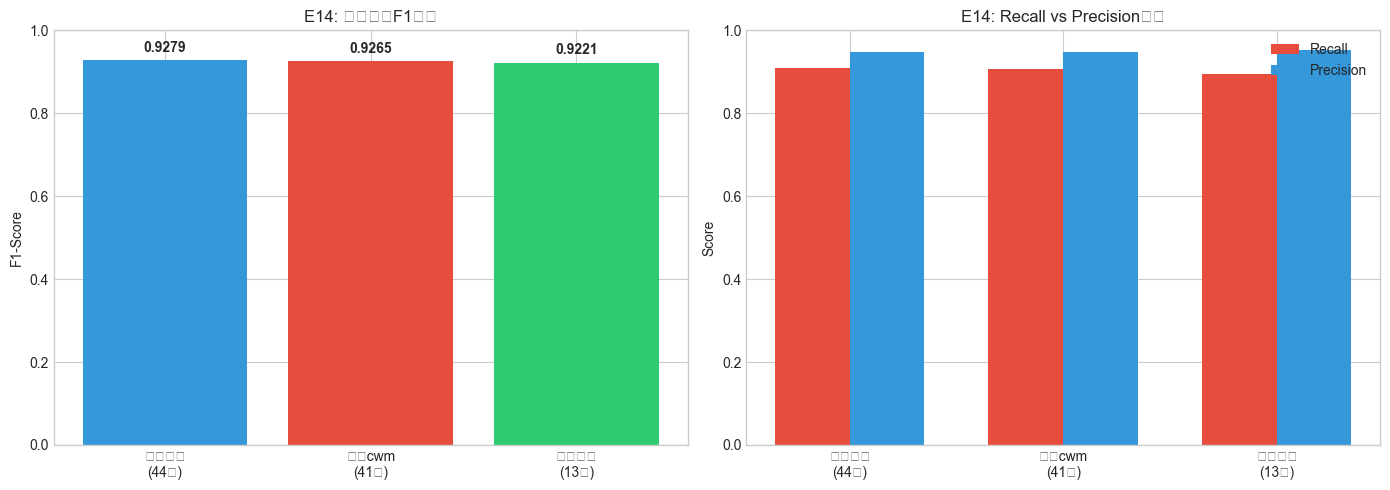


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e14_feature_analysis.png


In [20]:
#   绘制E14ComparisonFigure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#   Figure1: F1Comparison
ax1 = axes[0]
experiments = e14_results['experiment'].str.replace('\n', ' ')
x = range(len(experiments))

bars = ax1.bar(x, e14_results['test_f1'], color=['#  3498db', '#e74c3c', '#2ecc71'])
ax1.set_xticks(x)
ax1.set_xticklabels(['全部特征\n(44个)', '排除cwm\n(41个)', '仅协议层\n(13个)'])
ax1.set_ylabel('F1-Score')
ax1.set_title('E14: 特征组合F1对比')
ax1.set_ylim(0, 1)

#   添加数值Labels
for bar, val in zip(bars, e14_results['test_f1']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

#   Figure2: Recall和PrecisionComparison
ax2 = axes[1]
width = 0.35
x = np.arange(len(experiments))

ax2.bar(x - width/2, e14_results['test_recall'], width, label='Recall', color='#  e74c3c')
ax2.bar(x + width/2, e14_results['test_precision'], width, label='Precision', color='#  3498db')
ax2.set_xticks(x)
ax2.set_xticklabels(['全部特征\n(44个)', '排除cwm\n(41个)', '仅协议层\n(13个)'])
ax2.set_ylabel('Score')
ax2.set_title('E14: Recall vs Precision对比')
ax2.set_ylim(0, 1)
ax2.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e14_feature_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e14_feature_analysis.png'}")

---

## 5. E15: Rule阈值调整Experiment (可选)

### 目的
Exploration不同 `cwm` 阈值下的Rule Layer效果，Analysis Recall-Precision trade-off。

In [21]:
print("\n" + "="*60)
print("E15: 规则阈值调整实验")
print("="*60)

#   Test不同阈值
thresholds = [0, 1, 2, 3, 5, 10, 15, 20]
threshold_results = []

for thresh in thresholds:
    y_pred_t, rule_mask_t = apply_simple_rule(df_test, threshold=thresh)
    metrics_t = evaluate_model(y_test, y_pred_t)
    
    #   Statistics覆盖率
    attack_coverage = (rule_mask_t & (df_test['label'] == 'Attack')).sum() / (df_test['label'] == 'Attack').sum()
    
    threshold_results.append({
        'threshold': thresh,
        'attack_coverage': attack_coverage,
        'accuracy': metrics_t['accuracy'],
        'precision': metrics_t['precision'],
        'recall': metrics_t['recall'],
        'f1': metrics_t['f1']
    })
    
    print(f"\ncwm > {thresh}:")
    print(f"  Attack覆盖率: {attack_coverage:.2%}")
    print(f"  Precision: {metrics_t['precision']:.4f}")
    print(f"  Recall: {metrics_t['recall']:.4f}")
    print(f"  F1: {metrics_t['f1']:.4f}")

df_threshold = pd.DataFrame(threshold_results)


E15: 规则阈值调整实验

cwm > 0:
  Attack覆盖率: 100.00%
  Precision: 0.6764
  Recall: 1.0000
  F1: 0.8070

cwm > 1:
  Attack覆盖率: 99.55%
  Precision: 0.6863
  Recall: 0.9955
  F1: 0.8125

cwm > 2:
  Attack覆盖率: 7.19%
  Precision: 1.0000
  Recall: 0.0719
  F1: 0.1342

cwm > 3:
  Attack覆盖率: 5.94%
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121

cwm > 5:
  Attack覆盖率: 5.94%
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121

cwm > 10:
  Attack覆盖率: 5.94%
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121

cwm > 15:
  Attack覆盖率: 5.94%
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121

cwm > 20:
  Attack覆盖率: 5.94%
  Precision: 1.0000
  Recall: 0.0594
  F1: 0.1121


In [22]:
#   保存E15Results
df_threshold.to_csv(TABLES_DIR / 'phase3.5_e15_threshold_analysis.csv', index=False)
print(f"\n✓ E15结果已保存")


✓ E15结果已保存


2026-01-22 14:21:47,188 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-22 14:21:47,190 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


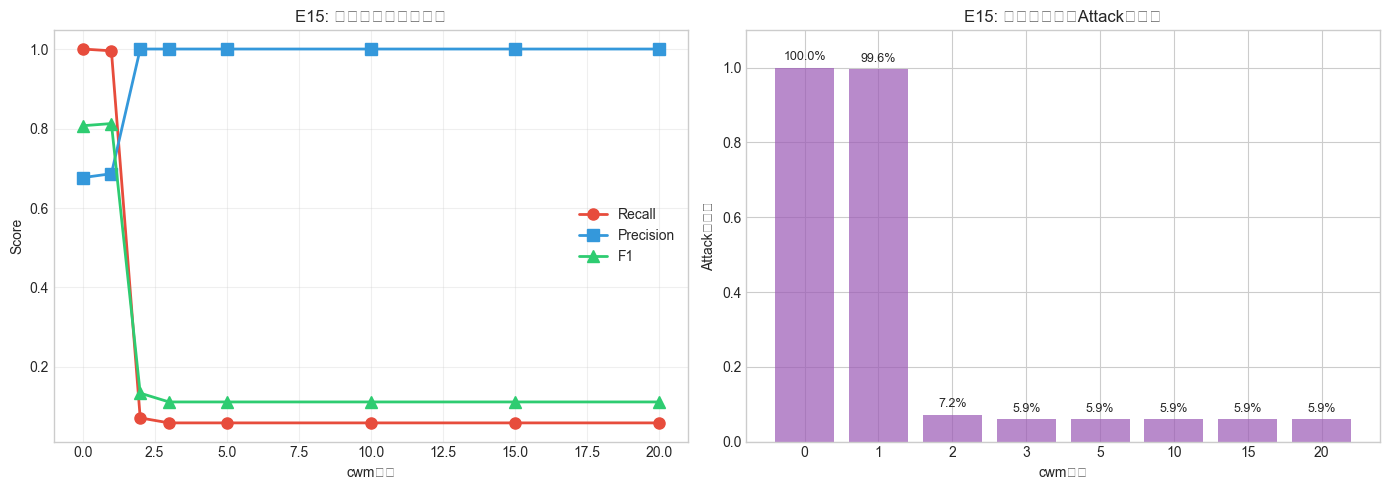


✓ Chart saved: c:\Users\Echo\Desktop\modbus-detection\results\figures\phase3.5_e15_threshold_analysis.png


In [23]:
#   绘制E15阈值AnalysisFigure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#   Figure1: Precision-RecallCurve
ax1 = axes[0]
ax1.plot(df_threshold['threshold'], df_threshold['recall'], 'o-', 
         label='Recall', color='#  e74c3c', linewidth=2, markersize=8)
ax1.plot(df_threshold['threshold'], df_threshold['precision'], 's-', 
         label='Precision', color='#  3498db', linewidth=2, markersize=8)
ax1.plot(df_threshold['threshold'], df_threshold['f1'], '^-', 
         label='F1', color='#  2ecc71', linewidth=2, markersize=8)

ax1.set_xlabel('cwm阈值')
ax1.set_ylabel('Score')
ax1.set_title('E15: 规则阈值敏感性分析')
ax1.legend()
ax1.grid(True, alpha=0.3)

#   Figure2: Attack覆盖率
ax2 = axes[1]
ax2.bar(df_threshold['threshold'].astype(str), df_threshold['attack_coverage'], 
        color='#  9b59b6', alpha=0.7)
ax2.set_xlabel('cwm阈值')
ax2.set_ylabel('Attack覆盖率')
ax2.set_title('E15: 不同阈值下的Attack覆盖率')
ax2.set_ylim(0, 1.1)

#   添加数值Labels
for i, (idx, row) in enumerate(df_threshold.iterrows()):
    ax2.text(i, row['attack_coverage'] + 0.02, f"{row['attack_coverage']:.1%}", 
             ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'phase3.5_e15_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Chart saved: {FIGURES_DIR / 'phase3.5_e15_threshold_analysis.png'}")

---

## 6. Phase 3.5 总结

In [24]:
print("="*60)
print("Phase 3.5 补充实验总结")
print("="*60)

print("\n【E13: 简单规则基线】")
print(f"  Simple Rule (cwm>0):")
print(f"    F1 = {metrics_rule_0['f1']:.4f}")
print(f"    Recall = {metrics_rule_0['recall']:.4f}")
print(f"    Precision = {metrics_rule_0['precision']:.4f}")
print(f"  Random Forest:")
print(f"    F1 = {metrics_rf['f1']:.4f}")
print(f"    相对简单规则F1变化: {(metrics_rf['f1'] - metrics_rule_0['f1'])/metrics_rule_0['f1']*100:+.2f}%")

print("\n【E14: Feature Analysis Excluding cwm】")
print(f"  全部特征 (44个): F1 = {metrics_all['f1']:.4f}")
print(f"  排除cwm (41个): F1 = {metrics_no_cwm['f1']:.4f}")
print(f"  cwm特征贡献: F1变化 = {metrics_all['f1'] - metrics_no_cwm['f1']:+.4f}")

print("\n【E15: 规则阈值分析】")
best_threshold_idx = df_threshold['f1'].idxmax()
best_row = df_threshold.loc[best_threshold_idx]
print(f"  最佳阈值: cwm > {best_row['threshold']}")
print(f"    F1 = {best_row['f1']:.4f}")
print(f"    Attack覆盖率 = {best_row['attack_coverage']:.2%}")

print("\n" + "="*60)
print("论文结论建议")
print("="*60)

if metrics_rule_0['f1'] > 0.95:
    print("\n⚠ 数据集特性：简单规则 cwm>0 可达到极高的检测性能")
    print("  - 说明该数据集的攻击模式高度集中于写操作异常")
    print("  - ML方法的额外价值主要在于：")
    print("    1) 提供概率输出和置信度")
    print("    2) 处理边界情况")
    print("    3) 潜在的更强泛化能力（需更复杂数据集验证）")
else:
    print("\n✓ ML方法相对于简单规则有显著增益")
    print(f"  F1增益: {metrics_rf['f1'] - metrics_rule_0['f1']:.4f}")

Phase 3.5 补充实验总结

【E13: 简单规则基线】
  Simple Rule (cwm>0):
    F1 = 0.8070
    Recall = 1.0000
    Precision = 0.6764
  Random Forest:
    F1 = 0.9279
    相对简单规则F1变化: +14.98%

【E14: Feature Analysis Excluding cwm】
  全部特征 (44个): F1 = 0.9279
  排除cwm (41个): F1 = 0.9265
  cwm特征贡献: F1变化 = +0.0014

【E15: 规则阈值分析】
  最佳阈值: cwm > 1.0
    F1 = 0.8125
    Attack覆盖率 = 99.55%

论文结论建议

✓ ML方法相对于简单规则有显著增益
  F1增益: 0.1209


In [25]:
#   生成Phase 3.5 总结报告
summary = f"""
#   Phase 3.5 补充Experiment总结

Execution time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

#  # E13: 简单Rule基线完整Evaluation

| 方法 | Accuracy | Precision | Recall | F1 |
|------|----------|-----------|--------|----|
| Simple Rule (cwm>0) | {metrics_rule_0['accuracy']:.4f} | {metrics_rule_0['precision']:.4f} | {metrics_rule_0['recall']:.4f} | {metrics_rule_0['f1']:.4f} |
| Random Forest | {metrics_rf['accuracy']:.4f} | {metrics_rf['precision']:.4f} | {metrics_rf['recall']:.4f} | {metrics_rf['f1']:.4f} |

**结论**: {'简单规则已可达到很高性能，ML方法增益有限' if metrics_rule_0['f1'] > 0.95 else 'ML方法相对简单规则有显著增益'}

#  # E14: 排除cwmFeaturesAnalysis

| 特征组 | 特征数 | CV F1 | Test F1 |
|--------|--------|-------|--------|
| 全部特征 | 44 | {cv_all['f1'].mean():.4f}±{cv_all['f1'].std():.4f} | {metrics_all['f1']:.4f} |
| 排除cwm | 41 | {cv_no_cwm['f1'].mean():.4f}±{cv_no_cwm['f1'].std():.4f} | {metrics_no_cwm['f1']:.4f} |
| 仅协议层 | 13 | {cv_protocol['f1'].mean():.4f}±{cv_protocol['f1'].std():.4f} | {metrics_protocol['f1']:.4f} |

**cwm特征贡献**: F1变化 = {metrics_all['f1'] - metrics_no_cwm['f1']:+.4f}

#  # E15: Rule阈值Analysis

最佳阈值: cwm > {best_row['threshold']}
- F1 = {best_row['f1']:.4f}
- Attack覆盖率 = {best_row['attack_coverage']:.2%}
"""

#   保存总结
with open(PROJECT_ROOT / 'docs' / 'PHASE3.5_SUMMARY.md', 'w', encoding='utf-8') as f:
    f.write(summary)

print(summary)
print(f"\n✓ 总结已保存: {PROJECT_ROOT / 'docs' / 'PHASE3.5_SUMMARY.md'}")


# Phase 3.5 补充实验总结

Execution time: 2026-01-22 14:21:47

## E13: Simple Rule Baseline Complete Evaluation

| 方法 | Accuracy | Precision | Recall | F1 |
|------|----------|-----------|--------|----|
| Simple Rule (cwm>0) | 0.9731 | 0.6764 | 1.0000 | 0.8070 |
| Random Forest | 0.9921 | 0.9484 | 0.9083 | 0.9279 |

**结论**: ML方法相对简单规则有显著增益

## E14: Feature Analysis Excluding cwm

| 特征组 | 特征数 | CV F1 | Test F1 |
|--------|--------|-------|--------|
| 全部特征 | 44 | 0.9491±0.0048 | 0.9279 |
| 排除cwm | 41 | 0.9509±0.0043 | 0.9265 |
| 仅协议层 | 13 | 0.9534±0.0054 | 0.9221 |

**cwm特征贡献**: F1变化 = +0.0014

## E15: 规则阈值分析

最佳阈值: cwm > 1.0
- F1 = 0.8125
- Attack覆盖率 = 99.55%


✓ 总结已保存: c:\Users\Echo\Desktop\modbus-detection\docs\PHASE3.5_SUMMARY.md


In [26]:
print("\n" + "="*60)
print("Phase 3.5 补充实验完成！")
print("="*60)


Phase 3.5 补充实验完成！
